In [1]:
import math
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, SGDClassifier
from sklearn import model_selection
import pubchempy as pcp

import IPython.display as Disp

# Plasticizer Likelihood

In [2]:
plasticizers = pd.read_pickle('../database/plasticizer_data_v5_high_var.pkl')
gdb = pd.read_pickle('../database/gdb17_5mil.pkl')

In [3]:
rdkit_cols = np.array(plasticizers.columns[5:])
rdkit_cols_abrg = rdkit_cols[np.where(rdkit_cols[np.where(rdkit_cols != 'MolWt')] != 'qed')]

In [4]:
def calc_kde(xis, lo, hi, h=0.17):
    kde = []
    xs = np.linspace(lo, hi, 101)
    for x in xs:
        kde_sum = 0
        for xi in xis:
            x_prime = (x - xi) / h
            kde_sum += 1 / (1 * math.sqrt(2*math.pi))*math.exp(-(1/2)*((x_prime - 0) / 1)**2)
        kde_sum /= len(xis)*h
        kde.append(kde_sum)
    return kde, xs

def get_kde_value(v, kde, xs):
    for i, x in enumerate(xs):
        if v < x:
            idx = i
            break
    val = kde[i]
    return val

def eval_acc(vs, boundary):
    hits = 0
    for v in vs:
        if v > boundary:
            hits += 1
        else:
            pass
    acc = hits / len(vs)
    return acc

def calc_2D_kde(x_vec, x_range, y_range, gridsize=101):
    # Using Scott's rule of thumb
    d = 2
    std_i = np.std(x_vec[:,0])
    std_j = np.std(x_vec[:,1])
    n = x_vec.shape[0]
    H_i = (n**(-1 / (d + 4))*std_i)**2
    H_j = (n**(-1 / (d + 4))*std_j)**2
    H = np.array([[H_i, 0], [0, H_j]])
    
    xs = np.linspace(x_range[0], x_range[1], gridsize)
    ys = np.linspace(y_range[0], y_range[1], gridsize)
    kde = np.zeros((gridsize, gridsize))
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            kde_sum = 0
            for k in range(x_vec.shape[0]):
                xi = x_vec[k,:]
                x_prime = np.array([x, y]) - xi
                val = (2*math.pi)**(-d/2)*(np.linalg.det(H))**(-1/2)*math.exp(-(1/2)*x_prime.T@np.linalg.inv(H)@x_prime)
                kde_sum += val
            kde_sum /= n
            kde[i,j] = kde_sum
    return kde.T, xs, ys

def get_2D_kde_value(v, kde, xs, ys):
    idxs = []
    for i, x in enumerate(xs):
        if v[0] < x:
            idxs.append(i)
            break
    for j, y in enumerate(ys):
        if v[1] < y:
            idxs.append(j)
            break
    val = kde.T[idxs[0], idxs[1]]
    return val

In [5]:
n=10000
gdb_all = gdb.sample(n=n)
gdb_smiles = gdb['smile'].to_numpy()
gdb_data = gdb[rdkit_cols].to_numpy()
rand_idxs = np.random.choice(np.arange(len(gdb_all)), size=len(gdb_all), replace=False)
train_idxs = rand_idxs[:168]
test_idxs = rand_idxs[168:1168]
vae_idxs = rand_idxs[1168:]
gdb_tr = gdb_data[train_idxs,:]
gdb_smiles_train = gdb_smiles[train_idxs]
gdb_te = gdb_data[test_idxs,:]
gdb_smiles_test = gdb_smiles[test_idxs]
gdb_vae = gdb_data[vae_idxs,:]
gdb_smiles_vae = gdb_smiles[vae_idxs]

pl_all = plasticizers[rdkit_cols].to_numpy()
pl_smiles = plasticizers['SMILES'].to_numpy()
rand_idxs = np.random.choice(np.arange(len(pl_all)), size=len(pl_all), replace=False)
train_idxs = rand_idxs[:168]
test_idxs = rand_idxs[168:]
pl_tr = pl_all[train_idxs,:]
pl_smiles_train = pl_smiles[train_idxs]
pl_te = pl_all[test_idxs,:]
pl_smiles_test = pl_smiles[test_idxs]

train_data = np.concatenate([pl_tr, gdb_tr], axis=0)
test_data = np.concatenate([pl_te, gdb_te], axis=0)

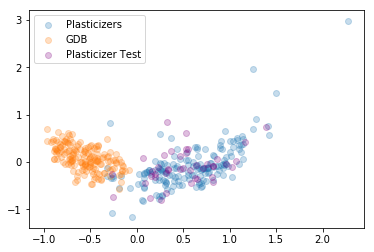

In [6]:
# PCA Model

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
pca = PCA(n_components=2)
train_ics = pca.fit_transform(train_data)
test_ics = pca.transform(test_data)
test_pl_ics = test_ics[:42,:]
test_gdb_ics = test_ics[42:,:]

pl_ics = train_ics[:168,:]
gdb_ics = train_ics[168:,:]

plt.scatter(pl_ics[:,0], pl_ics[:,1], label='Plasticizers', alpha=0.25)
plt.scatter(gdb_ics[:,0], gdb_ics[:,1], label='GDB', alpha=0.25)
plt.scatter(test_pl_ics[:,0], test_pl_ics[:,1], label='Plasticizer Test', alpha=0.25, c='purple')
plt.legend(loc='best')
plt.show()

### Using 1D KDE

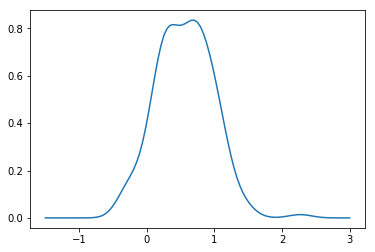

In [7]:
kde, xs = calc_kde(pl_ics[:,0], -1.5, 3.0)
plt.plot(xs, kde)
plt.show()

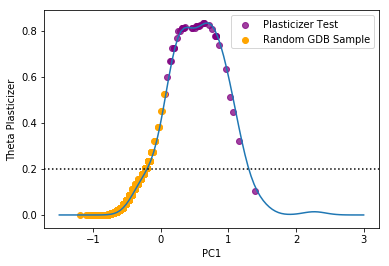

In [8]:
pl_test_kdes = []
pl_train_kdes = []
gdb_kdes = []
for pl_sample in test_pl_ics[:,0]:
    pl_test_kdes.append(get_kde_value(pl_sample, kde, xs))
for pl_sample in pl_ics[:,0]:
    pl_train_kdes.append(get_kde_value(pl_sample, kde, xs))
for gdb_sample in test_gdb_ics[:,0]:
    gdb_kdes.append(get_kde_value(gdb_sample, kde, xs))
plt.plot(xs, kde)
plt.scatter(test_pl_ics[:,0], pl_test_kdes, c='purple', alpha=0.75, label='Plasticizer Test')
plt.scatter(test_gdb_ics[:,0], gdb_kdes, c='orange', label='Random GDB Sample')
plt.axhline(0.2, c='black', ls=':')
plt.legend(loc='best')
plt.xlabel('PC1')
plt.ylabel('Theta Plasticizer')
plt.show()

In [9]:
boundary = 0.2
pl_train_acc = eval_acc(pl_train_kdes, boundary)
pl_test_acc = eval_acc(pl_test_kdes, boundary)
gdb_hit_percent = eval_acc(gdb_kdes, boundary)
print("Train Accuracy - {}%".format(round(pl_train_acc*100, 2)))
print("Test Accuracy - {}%".format(round(pl_test_acc*100, 2)))
print("GDB Hit Percent - {}% ({} / {} samples)".format(round(gdb_hit_percent*100, 2), int(gdb_hit_percent*len(gdb_kdes)), len(gdb_kdes)))

Train Accuracy - 93.45%
Test Accuracy - 92.86%
GDB Hit Percent - 9.1% (91 / 1000 samples)


In [10]:
pl_train_misses = pl_smiles_train[np.where(np.array(pl_train_kdes) < 0.2)]
pl_test_misses = pl_smiles_test[np.where(np.array(pl_test_kdes) < 0.2)]
gdb_hits = gdb_smiles_test[np.where(np.array(gdb_kdes) > 0.2)]

In [11]:
gdb_kdes, gdb_smiles = zip(*reversed(sorted(zip(gdb_kdes, gdb_smiles_test))))

In [12]:
urls = []
for hit in gdb_smiles[:10]:
    url = 'https://cactus.nci.nih.gov/chemical/structure/{}/image'.format(hit)
    urls.append(url)

In [13]:
normalizer = max(pl_test_kdes)

0.6290937736869315


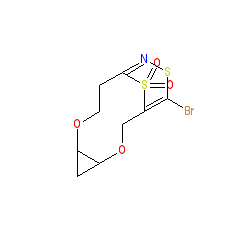

In [14]:
print(gdb_kdes[0] / normalizer)
Disp.Image(requests.get(urls[0]).content)

0.5398576216595756


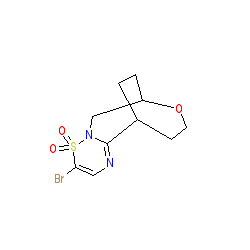

In [15]:
print(gdb_kdes[1] / normalizer)
Disp.Image(requests.get(urls[1]).content)

0.5398576216595756


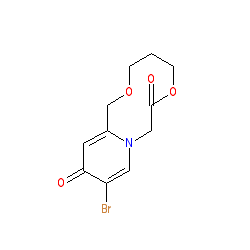

In [16]:
print(gdb_kdes[2] / normalizer)
Disp.Image(requests.get(urls[2]).content)

0.4572921595961523 BrC1=CC(=O)C2=C(CCOCOC(=O)C2)S1


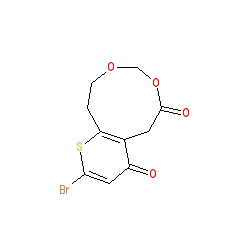

In [19]:
print(gdb_kdes[4] / normalizer, gdb_smiles[4])
Disp.Image(requests.get(urls[4]).content)

0.4572921595961523


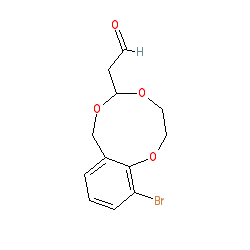

In [18]:
print(gdb_kdes[5] / normalizer)
Disp.Image(requests.get(urls[5]).content)

0.06850341278541465


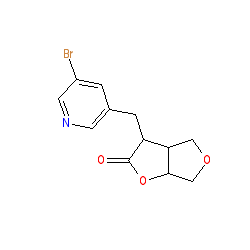

In [79]:
print(gdb_kdes[6] / normalizer)
Disp.Image(requests.get(urls[6]).content)

### Using 2D KDE

In [9]:
kde, xs, ys = calc_2D_kde(pl_ics, [-1.5,3.0], [-2.0,2.5])

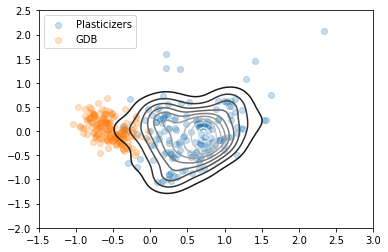

In [10]:
plt.contour(xs, ys, kde, levels=10, cmap='gray')
plt.scatter(pl_ics[:,0], pl_ics[:,1], label='Plasticizers', alpha=0.25)
plt.scatter(gdb_ics[:,0], gdb_ics[:,1], label='GDB', alpha=0.25)
plt.legend(loc='best')
plt.show()

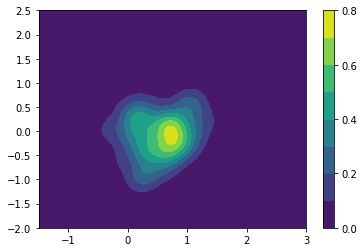

In [18]:
cmap = cm.get_cmap('viridis')
psm = plt.contourf(xs, ys, kde, cmap=cmap)
cbar = plt.colorbar(ticks=v)
plt.show()


In [88]:
pl_test_kdes = []
pl_train_kdes = []
gdb_kdes = []
for pl_sample in test_pl_ics:
    pl_test_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
for pl_sample in pl_ics:
    pl_train_kdes.append(get_2D_kde_value(pl_sample, kde, xs, ys))
for gdb_sample in test_gdb_ics:
    gdb_kdes.append(get_2D_kde_value(gdb_sample, kde, xs, ys))

In [94]:
boundary = 0.2
pl_train_acc = eval_acc(pl_train_kdes, boundary)
pl_test_acc = eval_acc(pl_test_kdes, boundary)
gdb_hit_percent = eval_acc(gdb_kdes, boundary)
print("Train Accuracy - {}%".format(round(pl_train_acc*100, 2)))
print("Test Accuracy - {}%".format(round(pl_test_acc*100, 2)))
print("GDB Hit Percent - {}% ({} / {} samples)".format(round(gdb_hit_percent*100, 2), int(gdb_hit_percent*len(gdb_kdes)), len(gdb_kdes)))

Train Accuracy - 81.55%
Test Accuracy - 78.57%
GDB Hit Percent - 8.13% (27 / 332 samples)


The 1 dimensional KDE appears to be the better discriminator for this set of data. Most of the variance between GDB and Plasticizer sets is contained in the first PCA component so adding information beyond that does not aid in the models predictive or discriminatory performance.

### MolWt and QED

In [29]:
n=500
gdb_all = gdb.sample(n=n).to_numpy()
gdb_abrg = gdb_all[:,np.where(rdkit_cols[np.where(rdkit_cols != 'MolWt')] != 'qed')].squeeze()
pl_all = plasticizers[rdkit_cols].to_numpy()
pl_abrg = plasticizers[rdkit_cols_abrg].to_numpy()
all_data = np.concatenate([pl_all, gdb_all], axis=0)
abrg_data = np.concatenate([pl_abrg, gdb_abrg], axis=0)

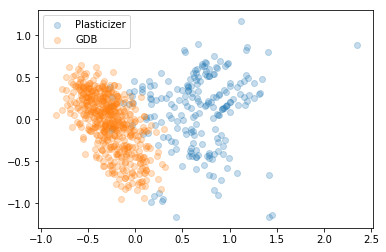

In [38]:
### With MolWt and QED

scaler = MinMaxScaler()
all_data = scaler.fit_transform(all_data)
pca = PCA(n_components=2)
all_ics = pca.fit_transform(all_data)

plt.scatter(all_ics[:210,0], all_ics[:210,1], label='Plasticizer', alpha=0.25)
plt.scatter(all_ics[210:,0], all_ics[210:,1], label='GDB', alpha=0.25)
plt.legend(loc='best')
plt.show()

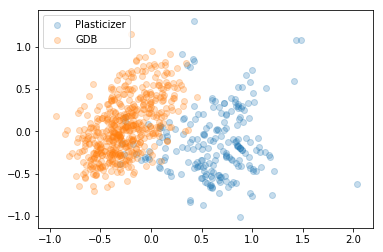

In [39]:
### With MolWt and QED

scaler = MinMaxScaler()
abrg_data = scaler.fit_transform(abrg_data)
pca = PCA(n_components=2)
abrg_ics = pca.fit_transform(abrg_data)

plt.scatter(abrg_ics[:210,0], abrg_ics[:210,1], label='Plasticizer', alpha=0.25)
plt.scatter(abrg_ics[210:,0], abrg_ics[210:,1], label='GDB', alpha=0.25)
plt.legend(loc='best')
plt.show()

PCA model is very similar for with and without MolWt and qed. We will leave them both and hope the VAE can build realistic molecules.